In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set_theme(style='darkgrid')
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
# Checking for missing values and duplicates
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [5]:
df.isna().sum()


Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [6]:
df.duplicated(subset = ['Customer Key']).sum()

5

In [7]:
df.drop_duplicates(subset = ['Customer Key'], inplace = True)

In [8]:
df.duplicated(subset = ['Customer Key']).sum()

0

In [9]:
# Now that the data is clean we move to EDA
# Descriptive statistics
#First we select the variables we will focus on
variables = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']
df[variables].describe().T




,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,655.0,34242.748092,37240.896986,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,655.0,4.691603,2.169325,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,655.0,2.401527,1.633648,0.0,1.0,2.0,4.0,5.0
Total_visits_online,655.0,2.606107,2.940380,0.0,1.0,2.0,4.0,15.0
Total_calls_made,655.0,3.601527,2.867352,0.0,1.0,3.0,5.0,10.0


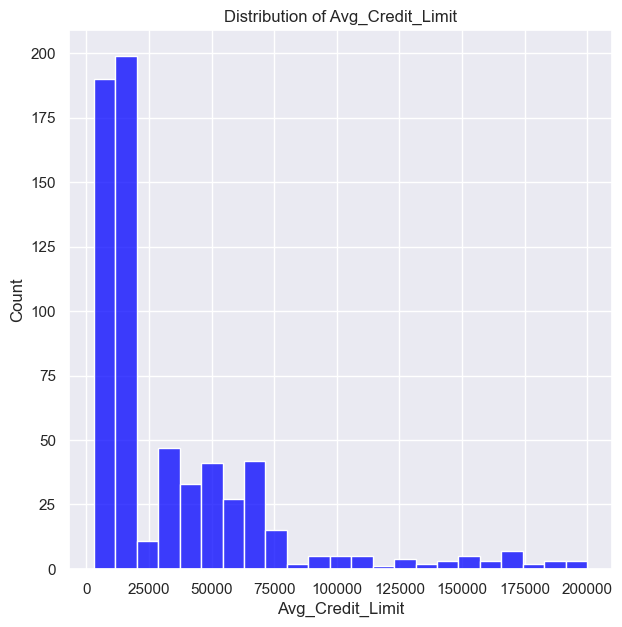

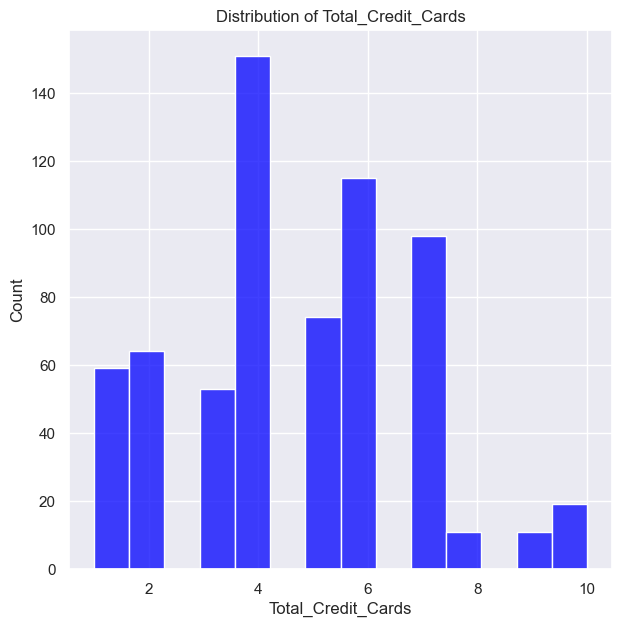

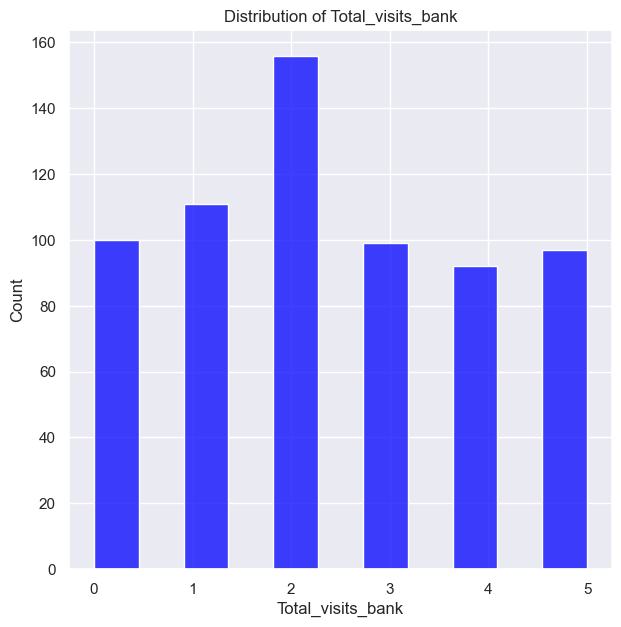

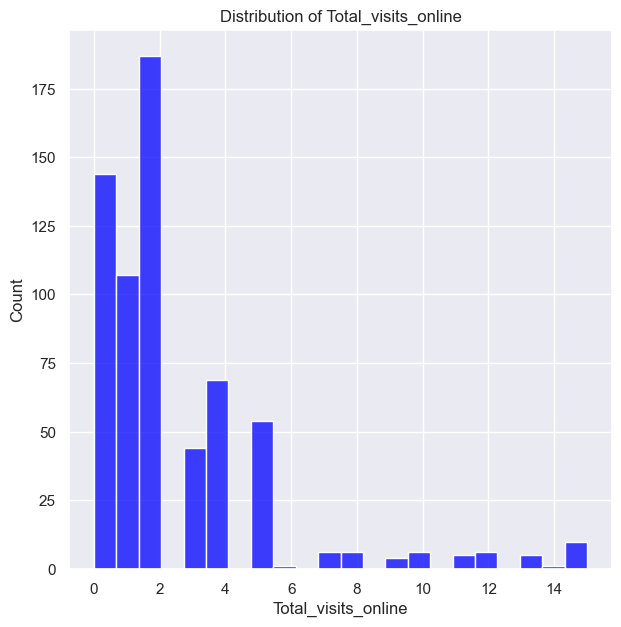

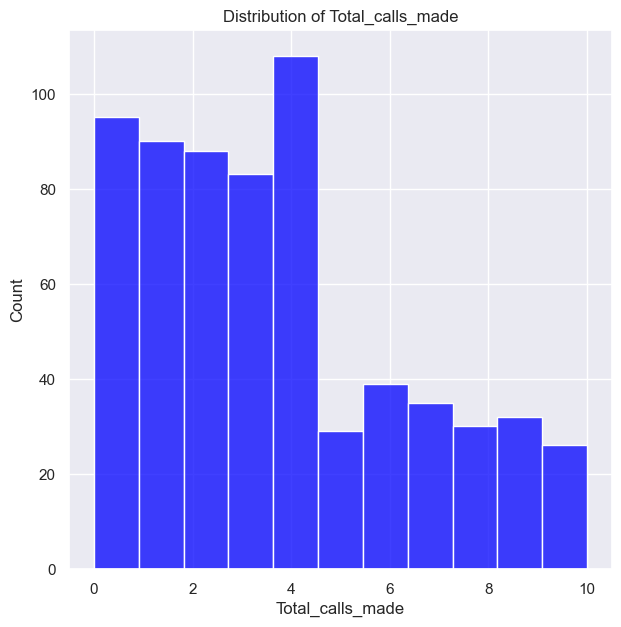

In [10]:
# Checking for the distribution of the variables
for variable in variables:
  plt.figure(figsize = (7, 7))
  sns.histplot(df[variable], color = "blue")
  plt.title(f'Distribution of {variable}')
  plt.show()

In [11]:
# Now We shall check the correlation between variables to see any relationship
correlation = df[variables].corr()
correlation


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.611015,-0.097462,0.551740,-0.412691
Total_Credit_Cards,0.611015,1.000000,0.316306,0.168144,-0.649331
Total_visits_bank,-0.097462,0.316306,1.000000,-0.552092,-0.508962
Total_visits_online,0.551740,0.168144,-0.552092,1.000000,0.128981
Total_calls_made,-0.412691,-0.649331,-0.508962,0.128981,1.000000


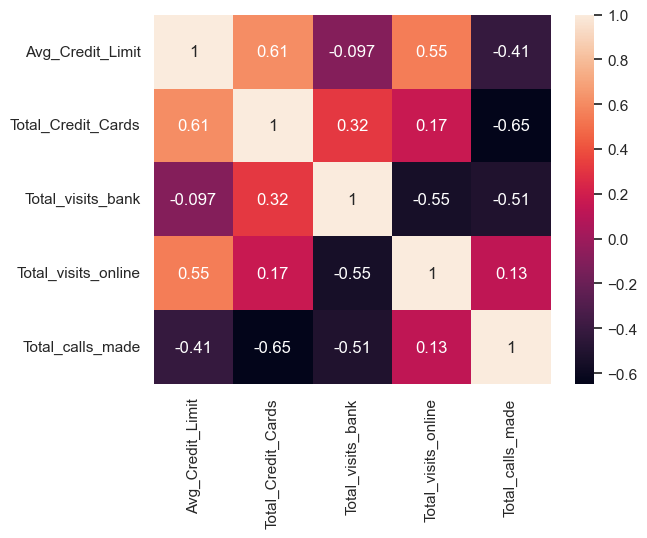

In [12]:
sns.heatmap(correlation, annot_kws={"size": 12}, annot = True)
plt.show()

**Avg Credit Limit & Total Credit Cards (0.611):** There’s a moderate positive correlation, meaning people with higher credit limits tend to have more credit cards.

**Total Credit Cards & Total Calls Made (-0.649):** A strong negative correlation suggests that customers with more credit cards tend to make fewer calls, possibly indicating more self-reliance or use of digital channels.

**Total Visits Bank & Total Visits Online (-0.552):** A moderate negative correlation shows that customers who visit the bank in person more frequently tend to visit online platforms less, indicating a clear distinction in user preferences.

**Total Visits Bank & Total Calls Made (-0.509):** People who visit the bank more tend to make fewer calls, suggesting they resolve most issues during in-person visits.

In [13]:
## Now we move to Clustering of the data , we shall begin my applying PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
pcadf = pca.fit(df[variables])

# Now we identify the number of components that explains 90% variation in the data
CumSum = np.cumsum(pcadf.explained_variance_ratio_)
Variations = np.argmax(CumSum >= 0.90) + 1
print(CumSum)



[0.99999999 1.         1.         1.         1.        ]


In [16]:
## Fitting the data with one component

pca = PCA(n_components = 2)
pcadf = pca.fit_transform(df[variables])

pcadf = pd.DataFrame(pcadf, columns = ['PC1', 'PC2'])
pcadf.head()


,PC1,PC2
0,65757.251725,-1.524010
1,15757.251976,9.277068
2,15757.251968,0.403979
3,-4242.748148,-0.220468
4,65757.252256,5.749221


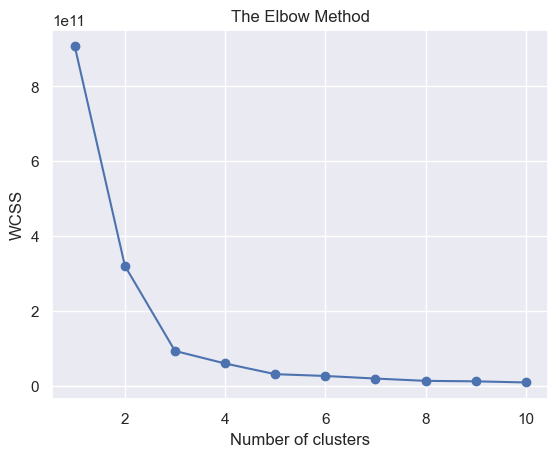

In [17]:
## Now we Identify the corect number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters = i,
                  init = 'k-means++',
                  random_state = 42)
  kmeans.fit(pcadf)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

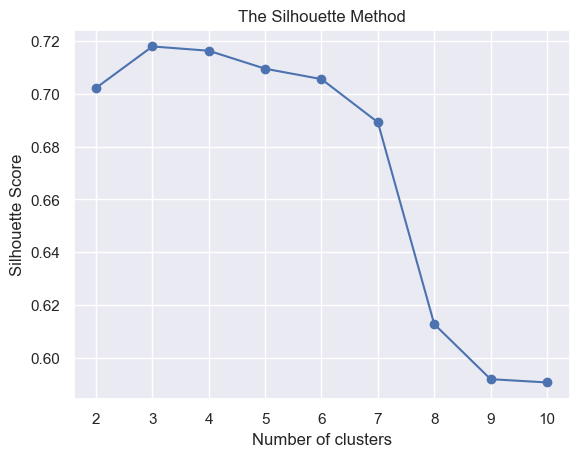

In [18]:
# Silthoutte
avg_score = []

for i in range(2, 11):
  kmeans = KMeans(n_clusters = i,
                  init = 'k-means++',
                  random_state = 42)
  kmeans.fit(pcadf)
  score = silhouette_score(pcadf, kmeans.labels_)
  avg_score.append(score)

plt.plot(range(2, 11), avg_score, marker = 'o')
plt.title('The Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [19]:
## We shall use three clusters to fit the Kmeans on the data
kmeans = KMeans(n_clusters = 3,
                init = 'k-means++',
                random_state = 42)
kmeans.fit(pcadf)
df['Clusters'] = kmeans.labels_
df.head()




,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Clusters
0,1,87073,100000,2,1,1,0,2
1,2,38414,50000,3,0,10,9,2
2,3,17341,50000,7,1,3,4,2
3,4,40496,30000,5,1,1,4,0
4,5,47437,100000,6,0,12,3,2


<Axes: xlabel='PC1', ylabel='PC2'>

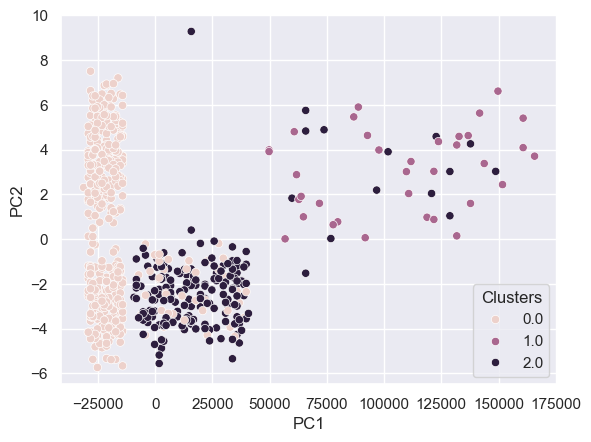

In [20]:
sns.scatterplot( x ='PC1', y = 'PC2', hue = df['Clusters'], data = pcadf)

In [22]:
# Now understanding the data with the new clusters
# First we shall add the cluster variable in the variables list
variables.append('Clusters')
df[variables].groupby('Clusters').describe().T


Clusters                              0              1              2
Avg_Credit_Limit    count    430.000000      38.000000     187.000000
                    mean   13841.860465  153342.105263   56951.871658
                    std     6988.376382   26516.977036   15663.903928
                    min     3000.000000  106000.000000   36000.000000
                    25%     8000.000000  131250.000000   44500.000000
                    50%    13000.000000  156500.000000   56000.000000
                    75%    18000.000000  172000.000000   68000.000000
                    max    35000.000000  200000.000000  100000.000000
Total_Credit_Cards  count    430.000000      38.000000     187.000000
                    mean       3.881395       8.789474       5.721925
                    std        1.885382       1.118829       1.443450
                    min        1.000000       7.000000       2.000000
                    25%        2.000000       8.000000       4.500000
                    50%        4.000000       9.000000       6.000000
                    75%        6.000000      10.000000       7.000000
                    max        7.000000      10.000000      10.000000
Total_visits_bank   count    430.000000      38.000000     187.000000
                    mean       2.209302       0.578947       3.213904
                    std        1.643780       0.500355       1.293997
                    min        0.000000       0.000000       0.000000
                    25%        1.000000       0.000000       2.000000
                    50%        2.000000       1.000000       3.000000
                    75%        4.000000       1.000000       4.000000
                    max        5.000000       1.000000       5.000000
Total_visits_online count    430.000000      38.000000     187.000000
                    mean       2.318605      10.973684       1.566845
                    std        1.609522       2.917671       2.673963
                    min        0.000000       7.000000       0.000000
                    25%        1.000000       8.000000       0.000000
                    50%        2.000000      11.000000       1.000000
                    75%        4.000000      13.000000       2.000000
                    max        5.000000      15.000000      15.000000
Total_calls_made    count    430.000000      38.000000     187.000000
                    mean       4.502326       1.026316       2.053476
                    std        3.004851       0.821562       1.519524
                    min        0.000000       0.000000       0.000000
                    25%        2.000000       0.000000       1.000000
                    50%        4.000000       1.000000       2.000000
                    75%        7.000000       2.000000       3.000000
                    max       10.000000       2.000000       9.000000

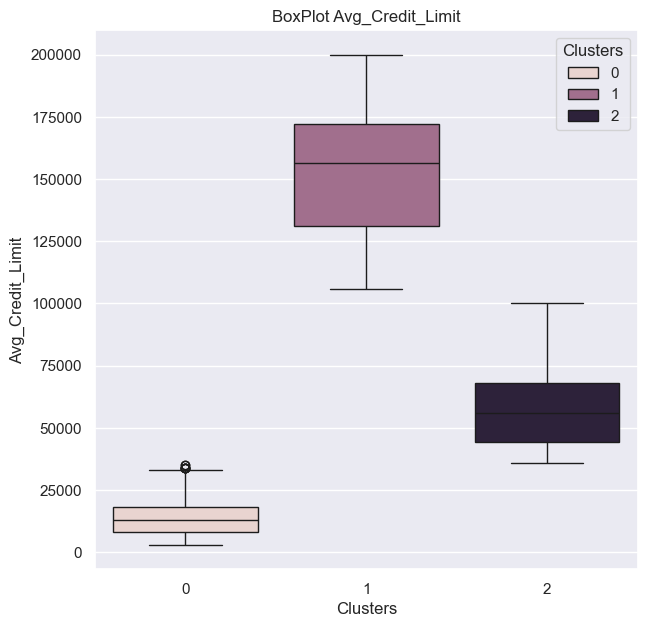

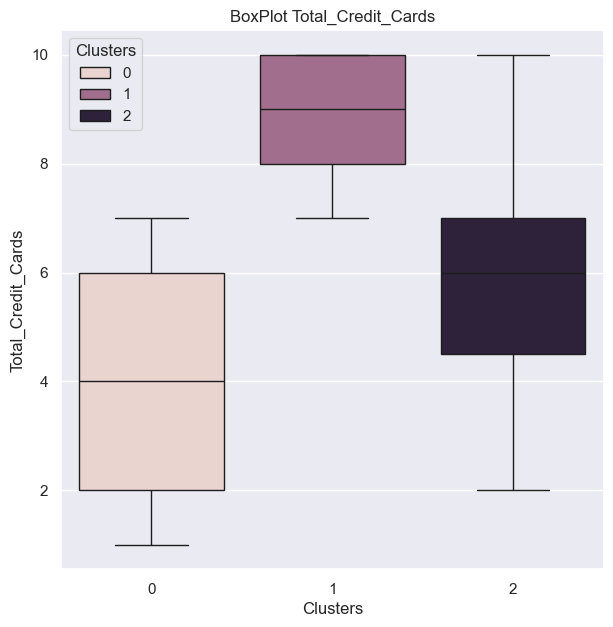

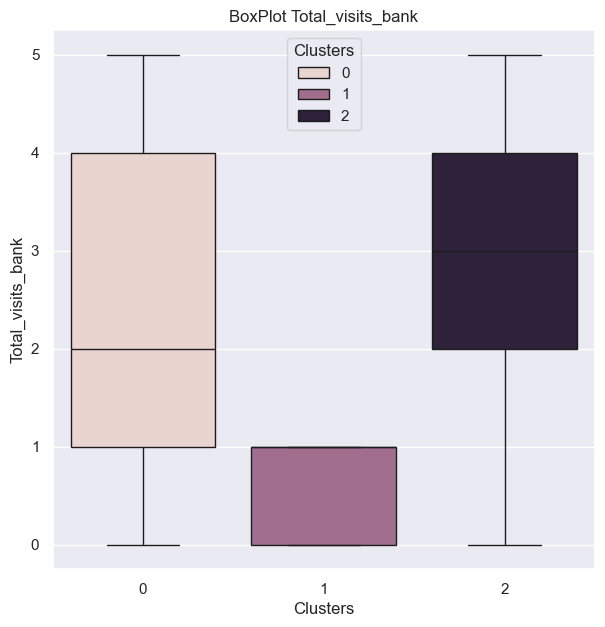

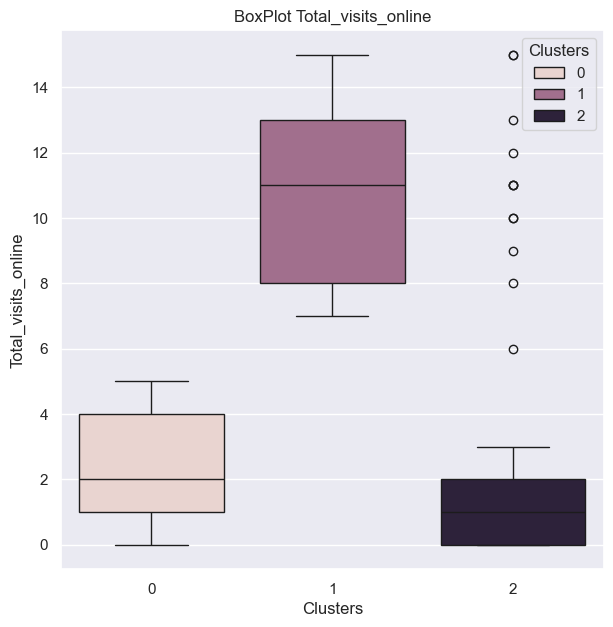

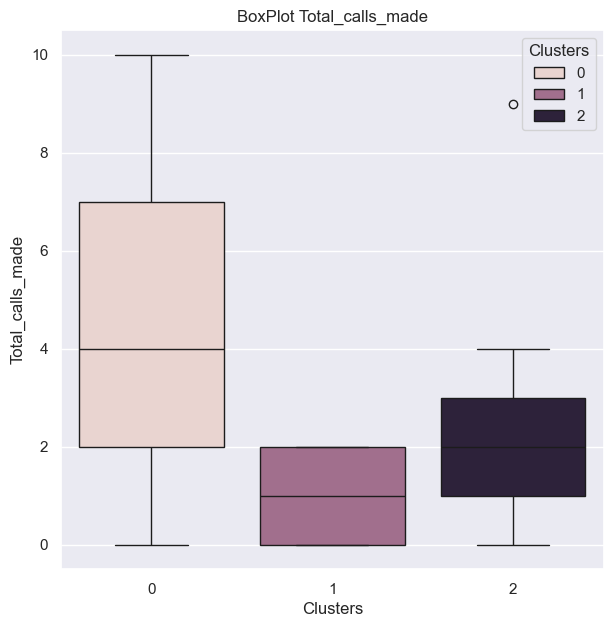

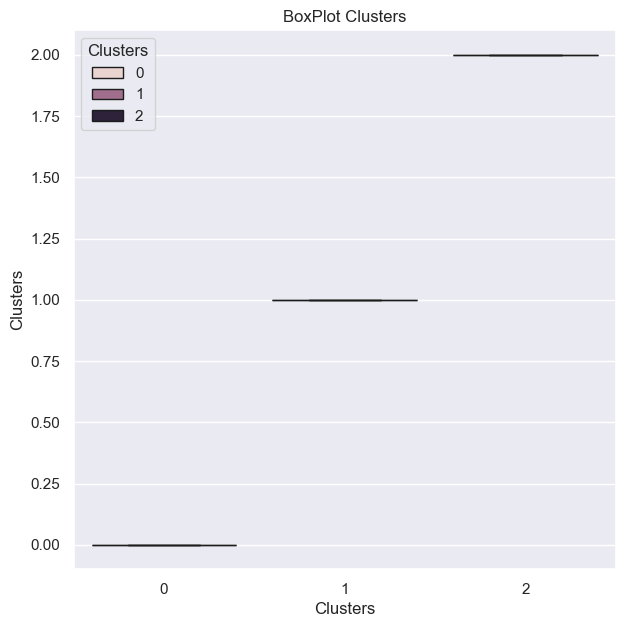

In [23]:
for variable in variables:
  plt.figure(figsize = (7, 7))
  plt.title(f"BoxPlot {variable}")
  sns.boxplot(x = 'Clusters', y = variable, hue = 'Clusters', data = df)
  plt.show()
# sns.boxplot(x = 'Clusters', y = 'Avg_Credit_Limit', data = df)
# plt.show()

**The way the data is segmented.**
* Cluster 0 (Low Credit, High Interaction):
This group has the lowest credit limit and moderate interaction through both online and offline channels.

* Cluster 1 (High Credit, Heavy Online Users):These are high-credit, high-value customers who heavily use online services and hold the most credit cards.

* Cluster 2 (Mid-Credit, High Bank Interaction):This group has mid-tier credit limits but engages frequently through in-person visits and less through online services.


**Recomendation**.
* **Cluster 0.**

  * Upsell: Offer credit limit increases or additional credit products (with caution), as they already engage frequently with calls and bank visits.

  * Incentivize Online Usage: Encourage them to shift towards more online services through promotional offers, as they engage less online compared to other clusters.

  * Cost Reduction: Consider reducing in-person service offerings or promoting self-service options to cut operational costs associated with their high call and visit interactions.



* **Cluster 1.**
 * Maintain Loyalty: Offer personalized rewards, premium services, or exclusive cards to retain these high-value customers, as they are the most digitally engaged and may have high lifetime value.

 * Digital-Only Products: Since they interact primarily online, consider offering more digital-first or online-exclusive products, such as virtual credit cards or enhanced mobile app features.

 * Automated Support: Given their low reliance on calls and visits, enhance digital customer support (e.g., AI chatbots) to further minimize the need for human interaction.


* **Cluster 2.**
 * Cross-Sell In-Person Services: Leverage their in-person engagement to cross-sell higher-value financial products like personal loans, investments, or insurance when they visit branches.

 * Promote Digital Transition: Encourage these customers to adopt more online banking services to reduce reliance on costly in-person interactions.

 * Targeted Offers: Provide in-branch incentives for mid-level credit increases or additional cards to capitalize on their frequent bank visits.



**Hierachical Clustering**

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering



In [25]:
df2 = df.copy()
df2.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Clusters
0,1,87073,100000,2,1,1,0,2
1,2,38414,50000,3,0,10,9,2
2,3,17341,50000,7,1,3,4,2
3,4,40496,30000,5,1,1,4,0
4,5,47437,100000,6,0,12,3,2


In [26]:
# Now dropping the cluster variable from the new copy data
df2.drop('Clusters', axis = 1, inplace = True)
df2.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [27]:
# Selecting variables for the clustering analysis
variables = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']


In [28]:
# First we will have to tandardize the data before the hierichial clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df2[variables] = scaler.fit_transform(df2[variables])
df2.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,1.767076,-1.241704,-0.858568,-0.546642,-1.257006
1,2,38414,0.423440,-0.780379,-1.471163,2.516526,1.884177
2,3,17341,0.423440,1.064922,-0.858568,0.134062,0.139075
3,4,40496,-0.114014,0.142271,-0.858568,-0.546642,0.139075
4,5,47437,1.767076,0.603597,-1.471163,3.197230,-0.209945


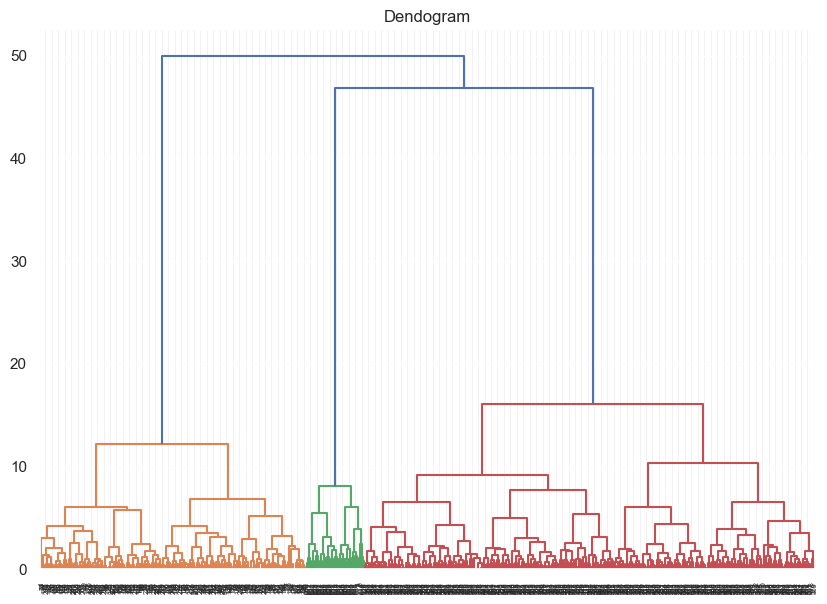

In [29]:

data = df2[variables]

# We begin with the Ward's method
Z = linkage(data, method = 'ward')

# Plotting the dendogram
plt.figure(figsize = (10, 7))
plt.title('Dendogram')
dendrogram(Z)
plt.show()

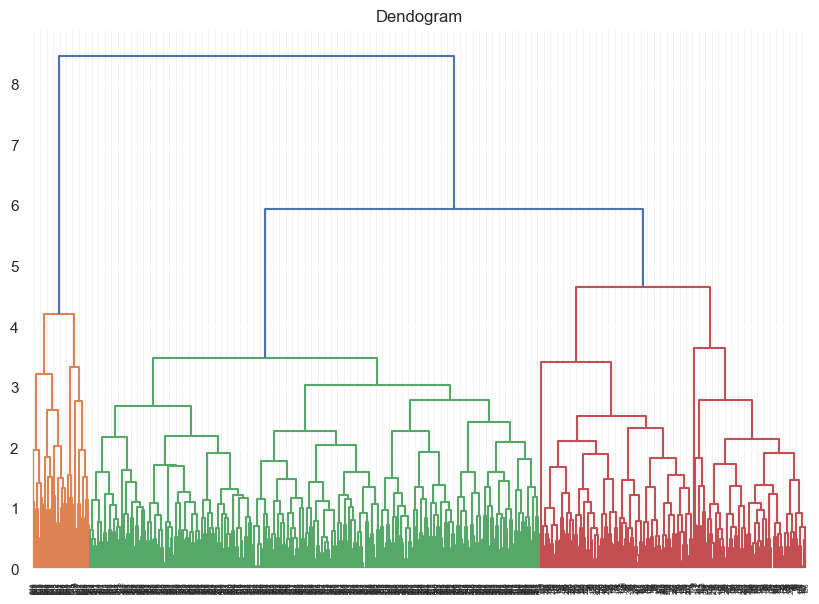

In [30]:
# Complete method
Z = linkage(data, method = "complete")

# Plotting
plt.figure(figsize = (10, 7))
plt.title('Dendogram')
dendrogram(Z)
plt.show()


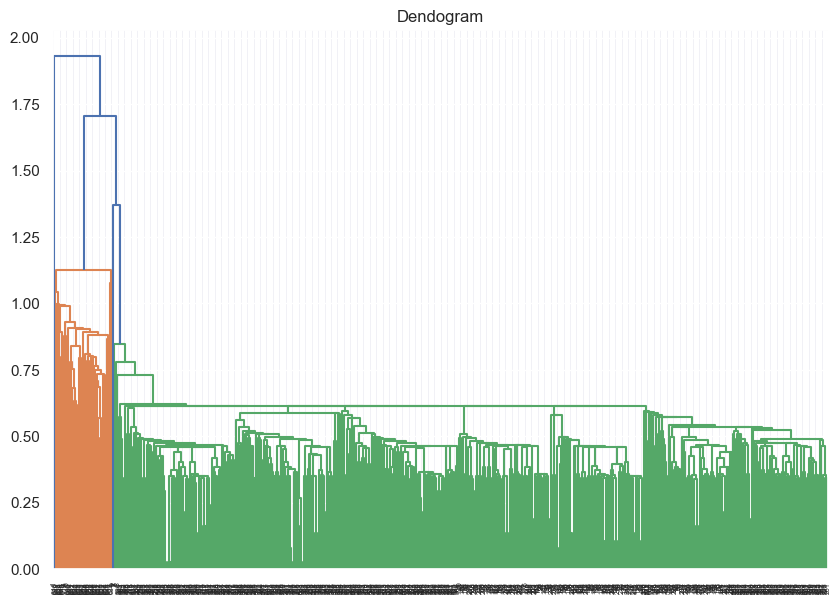

In [31]:
# Single
Z = linkage(data, method = "single")

# Plotting
plt.figure(figsize = (10, 7))
plt.title('Dendogram')
dendrogram(Z)
plt.show()


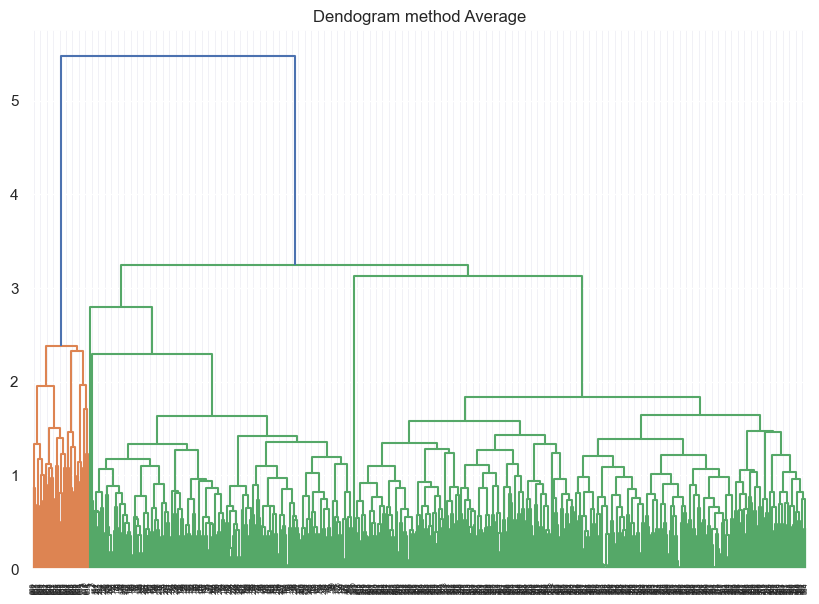

In [32]:
Z = linkage(data, method = "average")

# Plotting
plt.figure(figsize = (10, 7))
plt.title('Dendogram')
dendrogram(Z)
plt.title('Dendogram method Average')
plt.show()

In [33]:
# Finding the best method using cophenet correlation
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet

linkage_methods = ['single', 'complete', 'average', 'ward']

for method in linkage_methods:
  Z = linkage(data, method = method)
  c, coph_dists = cophenet(Z, pdist(data))

  print(f"Cophenetic Correlation for {method}: {c}")

Cophenetic Correlation for single: 0.7392346514952489
Cophenetic Correlation for complete: 0.8672981179730402
Cophenetic Correlation for average: 0.8978684505898265
Cophenetic Correlation for ward: 0.7392392076250658


In [34]:
# Average method will be used with 3 clusters
hc = AgglomerativeClustering(n_clusters = 3,
                             metric = 'euclidean',
                             linkage = 'average')

hc.fit(data)
labels = hc.labels_
df2 = df
df2['Clusters'] = labels
df2.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Clusters
0,1,87073,100000,2,1,1,0,0
1,2,38414,50000,3,0,10,9,2
2,3,17341,50000,7,1,3,4,0
3,4,40496,30000,5,1,1,4,0
4,5,47437,100000,6,0,12,3,1


In [36]:
variables.append('Clusters')
df2[variables].groupby('Clusters').describe().T

Clusters                               0              1             2
Avg_Credit_Limit    count     383.000000      49.000000    223.000000
                    mean    33535.248042  140102.040816  12197.309417
                    std     22137.556286   34163.970360   5249.332169
                    min      5000.000000   84000.000000   3000.000000
                    25%     13000.000000  108000.000000   8000.000000
                    50%     31000.000000  145000.000000  12000.000000
                    75%     51000.000000  167000.000000  16000.000000
                    max    100000.000000  200000.000000  50000.000000
Total_Credit_Cards  count     383.000000      49.000000    223.000000
                    mean        5.501305       8.775510      2.403587
                    std         1.141494       1.262691      1.098068
                    min         2.000000       5.000000      1.000000
                    25%         4.000000       8.000000      1.000000
                    50%         6.000000       9.000000      2.000000
                    75%         6.000000      10.000000      3.000000
                    max         7.000000      10.000000      4.000000
Total_visits_bank   count     383.000000      49.000000    223.000000
                    mean        3.490862       0.591837      0.928251
                    std         1.134557       0.496587      0.802171
                    min         1.000000       0.000000      0.000000
                    25%         3.000000       0.000000      0.000000
                    50%         3.000000       1.000000      1.000000
                    75%         5.000000       1.000000      2.000000
                    max         5.000000       1.000000      2.000000
Total_visits_online count     383.000000      49.000000    223.000000
                    mean        0.979112      10.979592      3.560538
                    std         0.858943       2.854016      1.217242
                    min         0.000000       6.000000      1.000000
                    25%         0.000000       8.000000      2.500000
                    50%         1.000000      11.000000      4.000000
                    75%         2.000000      13.000000      4.000000
                    max         3.000000      15.000000     10.000000
Total_calls_made    count     383.000000      49.000000    223.000000
                    mean        2.010444       1.102041      6.883408
                    std         1.436217       0.871897      1.985271
                    min         0.000000       0.000000      1.000000
                    25%         1.000000       0.000000      5.000000
                    50%         2.000000       1.000000      7.000000
                    75%         3.000000       2.000000      9.000000
                    max         4.000000       3.000000     10.000000

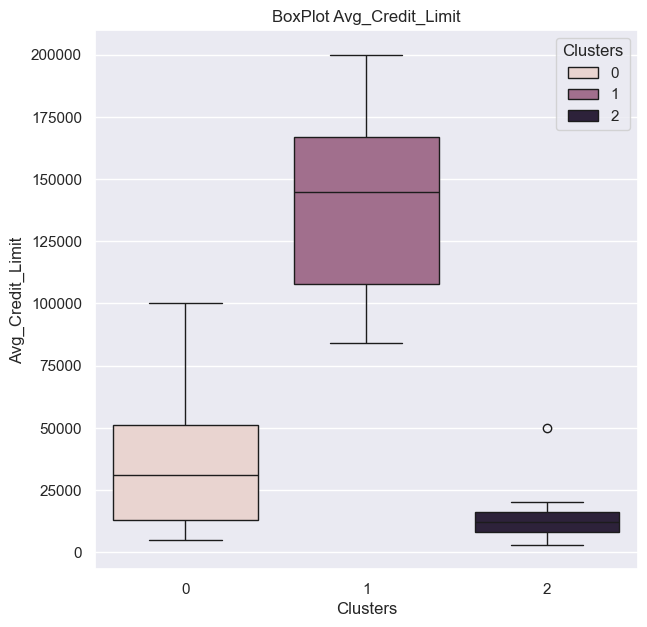

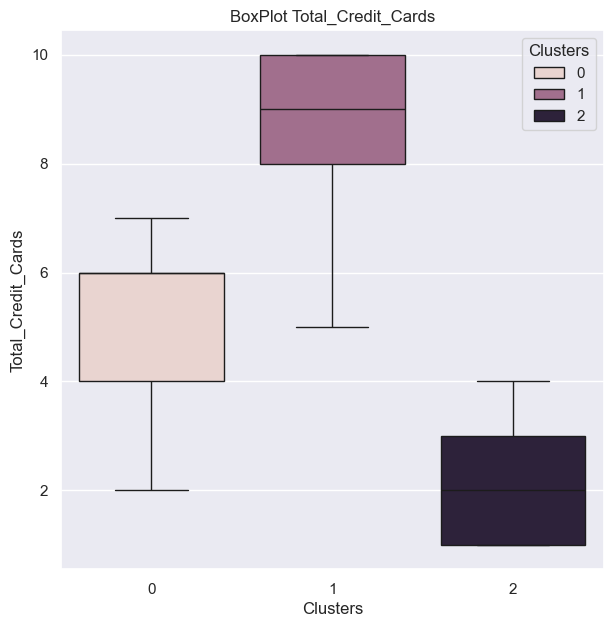

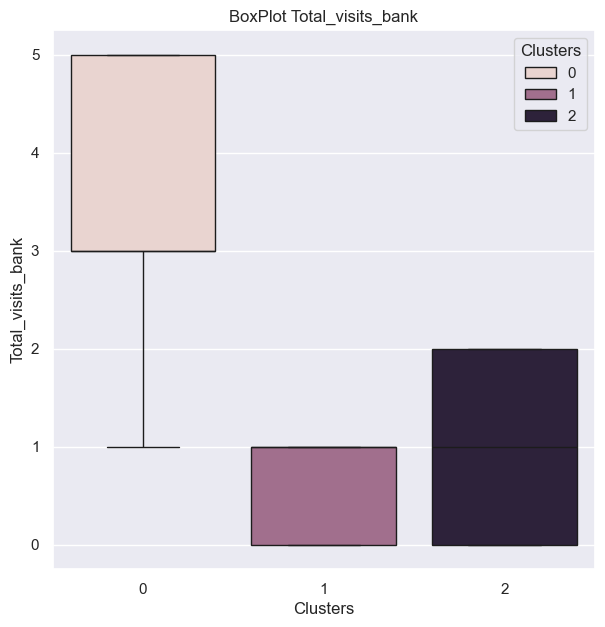

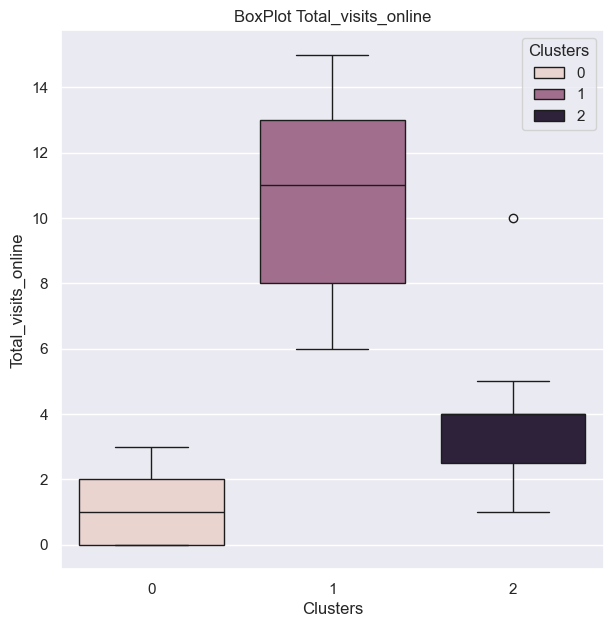

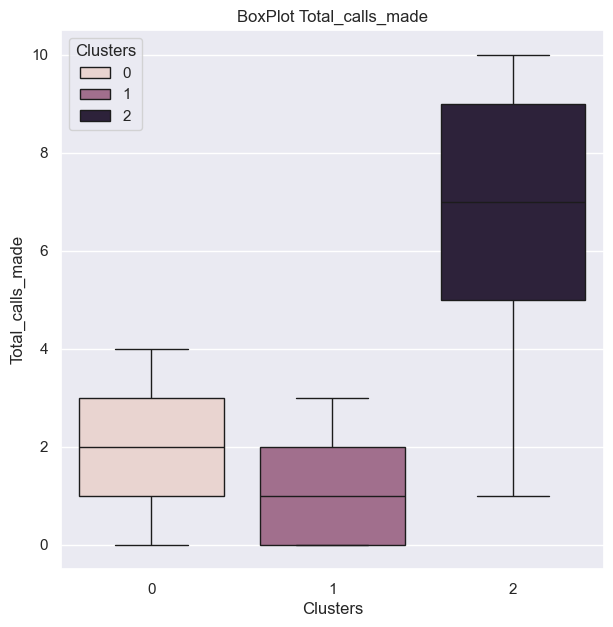

In [37]:
variables = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']

for variable in variables:
  plt.figure(figsize = (7, 7))
  plt.title(f"BoxPlot {variable}")
  sns.boxplot(x = 'Clusters', y = variable, hue = 'Clusters', data = df2)
  plt.show()


**Cluster 0: "Branch Reliant Savers"**
This group prefers in-person banking with moderate credit limits and online activity.

**Cluster 1: "Elite Digital Users"**
High-credit-limit customers who heavily use online banking and rarely visit branches or make calls.

**Cluster 2: "Support Seekers"**
Low-credit-limit customers who rely on phone support and make fewer visits to the bank and online channels.
These names reflect the key be



**Overall Strategy**
* **Personalized Marketing:**
 * Develop cluster-specific campaigns. For Cluster 1, focus on exclusive digital services; for Cluster 0, promote in-branch offers; and for Cluster 2, offer more support and credit-building tools.

* **Digital Transformation:**
  *  Across all clusters, aim to shift customers toward digital services. Clusters 0 and 2 need the most encouragement, while Cluster 1 should receive enhanced digital offerings.

* **Operational Efficiency**:
 * Reducing reliance on in-person visits (Cluster 0) and calls (Cluster 2) by promoting online services can help reduce operational costs.